# Case Study 2 - Real-time Appliance Usage Modelling

This case study demonstrates how individual appliances can be disaggregated from a building's total electricity consumption, and how deviations from normal routines can be detected automatically. The target data source is 10 second power data which can be streamed from UK smart electricity meters in real-time over the in-home ZigBee network.

The code below is part of a [iPython Notebook](http://ipython.org/notebook.html) (a.k.a [Jupyter](https://jupyter.org/)), which allows code, output and explanatory text to be included in a single file. The notebook can be opened by first installing iPython ([Anaconda](https://www.continuum.io/downloads) is recommended), opening a terminal window, navigating to the location of this notebook, and running the command: `ipython notebook`. The notebook can then be executed after installing the packages below ([NILMTK](https://github.com/nilmtk/nilmtk) etc.) by chosing 'Cell' -> 'Run All'.

In [1]:
%matplotlib inline
from datetime import time, datetime, timedelta
import numpy as np
import pandas as pd
from sklearn import mixture
import matplotlib.pyplot as plt
from matplotlib import rcParams
from pylab import arange,pi,sin,cos,sqrt
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (14, 6)})

# https://github.com/nilmtk/nilmtk/blob/master/docs/manual/user_guide/install.md
from nilmtk import DataSet
from nilmtk.datastore import HDFDataStore
from nilmtk.disaggregate.maximum_likelihood_estimation import MLE
from nilmtk.metergroup import MeterGroup

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

/Users/sobrison/anaconda/envs/nilmtk-env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Open UK Domestic Appliance-Level Electricity (UK-DALE) data set

In [2]:
# UK-DALE data set available from http://www.doc.ic.ac.uk/~dk3810/data/
# it can be downloaded in raw format and converted using the lines below

#from nilmtk.dataset_converters import convert_ukdale
#convert_ukdale('/Users/oliver.parson/Downloads/uk-power-data-download','/Users/oliver.parson/Downloads/ukdale.h5')

In [98]:
# the data set can then be loaded as shown below
# alternatively the data set can be downloaded directly in HDF5 format

ds = DataSet('data/ukdale.h5')

In [99]:
elec = ds.buildings[1].elec
print elec

MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='UK-DALE', appliances=[Appliance(type='boiler', instance=1)])
  ElecMeter(instance=3, building=1, dataset='UK-DALE', appliances=[Appliance(type='solar thermal pumping station', instance=1)])
  ElecMeter(instance=4, building=1, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=1), Appliance(type='laptop computer', instance=3)])
  ElecMeter(instance=5, building=1, dataset='UK-DALE', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=6, building=1, dataset='UK-DALE', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='UK-DALE', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=8, building=1, dataset='UK-DALE', appliances=[Appliance(type='light', instance=1), Appliance(type='light', instance=2)])
  ElecMeter(instance=9, building=1, dataset='UK-DALE', appliances=[Appliance(type='HTPC', instance=1)])
  Ele

In [100]:
elec_mains = elec.mains()
kettle=elec['kettle']

In [101]:
print mains.get_timeframe()
print kettle.get_timeframe()

TypeError: Cannot compare tz-naive and tz-aware timestamps

# Plot one day of aggregate and kettle power data

It can be seen that some of the large and short spikes in usage throughout the day are a result of kettle usage.

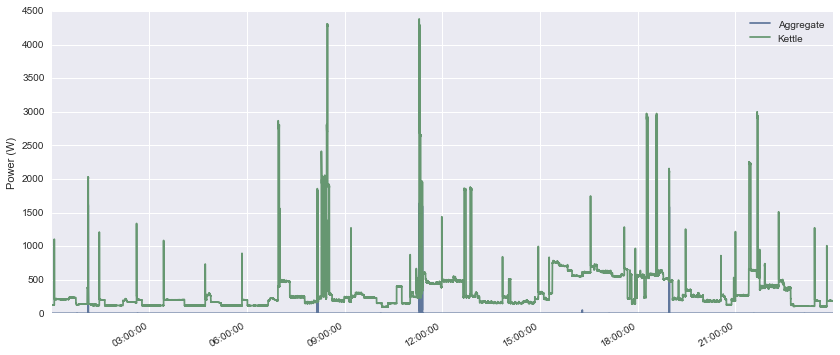

In [91]:
from nilmtk import TimeFrame
timeframe=TimeFrame('2013-03-18','2013-03-19')
elec_mains.store.window=timeframe
microwave.store.window=timeframe
microwave.power_series_all_data().plot()
elec_mains.power_series_all_data().plot()
plt.legend(['Aggregate','Kettle'])
plt.ylabel('Power (W)')

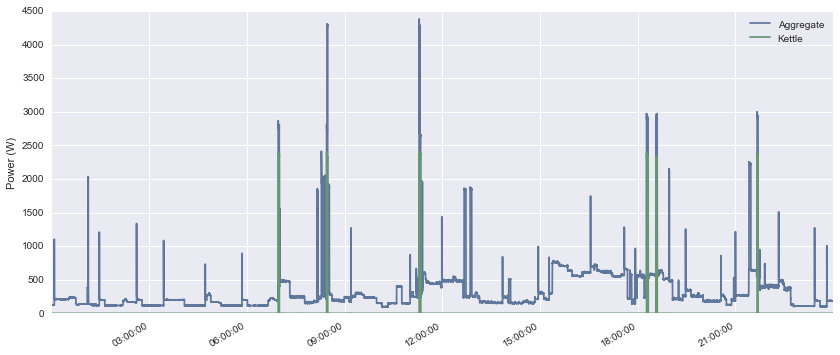

In [5]:
start = pd.Timestamp('2013-03-18')
end = pd.Timestamp('2013-03-19')
elec_mains[(elec_mains.index>start) & (elec_mains.index<end)].plot()
kettle[(kettle.index>start) & (kettle.index<end)].plot()
plt.legend(['Aggregate','Kettle'])
plt.ylabel('Power (W)')

In [6]:
# print total duration of each time series

mains_meter_group = elec.mains()
print mains_meter_group.get_timeframe()

kettle_meter = elec.meters[8]
print kettle_meter.get_timeframe()

TimeFrame(start='2013-03-17 19:12:43.100000+00:00', end='2015-01-05 06:27:12+00:00', empty=False)
TimeFrame(start='2012-11-09 22:28:18+00:00', end='2015-01-05 06:16:04+00:00', empty=False)


# Disaggregate kettle from 10 second electricity data

We can disaggregate the kettle usage by first learning a model of the kettle's electrical signature, and then matching the aggregate electricity usage against this signature.

In [7]:
# create maximum likelihood disaggregator
mle = MLE()

# set model parameters for training
mle.sampling_method = 'median'
mle.sample_period = '10s'
mle.thDelta = 2000

# train model on sub-metered data
mg = MeterGroup(meters=[kettle_meter])
mle.train(mg)

Training on chunk
Samples of onpower: 3247
Samples of offpower: 3247
Samples of duration: 3247
Training onpower
Training offpower
Training duration


# Plot learned model of kettle usage against actual kettle data

It can be seen that the 'on power' and 'off power' step changes are roughly the same magnitude and follow a similar distribution. The duration of the signature is also relatively constant, although it shows higher variation than the power step changes as the kettle boiling time is dependent on the amount of water in the kettle.

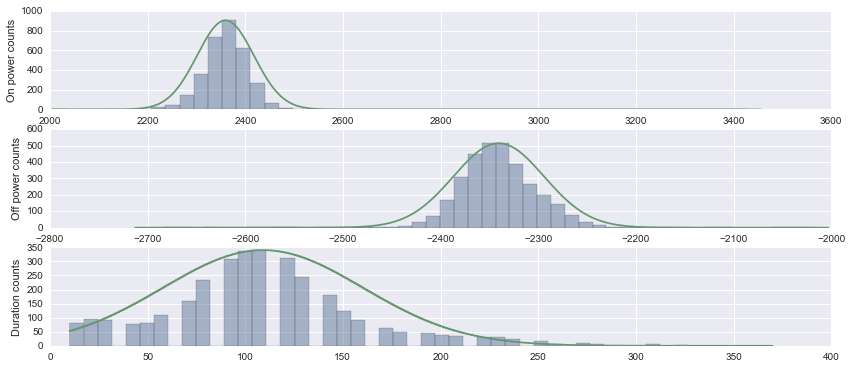

In [8]:
mle.featuresHist()

In [ ]:
# set disaggregation parameters 
mle.powerNoise = 2200 # Background noise in the main
mle.powerPair = 200 # Max diff between onpower and offpower
mle.timeWindow = 250 # To avoid high computation
mle.thLikelihood = 1e-10 # Threshold above which events are classed as kettle

# disaggregate kettle and save results to file
disag_store_path = 'data/ukdale_disag_3.h5'
disag_store = HDFDataStore(disag_store_path, 'w')
mle.disaggregate(mains_meter_group, disag_store)

In [10]:
# open disaggregated data file
disag_ds = DataSet(disag_store_path)

# print meters
disag_ds.buildings[1].elec.meters

[ElecMeter(instance=1, building=1, dataset='NILMTK_MLE_2015-10-09T09:22:36', site_meter, appliances=[]),
 ElecMeter(instance=2, building=1, dataset='NILMTK_MLE_2015-10-09T09:22:36', appliances=[Appliance(type='kettle', instance=1)])]

In [9]:
# load disaggregated kettle time series into memory

kettle_disag = disag_ds.buildings[1].elec.meters[1].power_series_all_data().sort_index()
print kettle_disag.shape
print kettle_disag.head()

agg_psad = disag_ds.buildings[1].elec.meters[0].power_series_all_data().sort_index()
print agg_psad.shape
print agg_psad.head()

NameError: name 'disag_ds' is not defined

# Plot aggregate data, sub-metered kettle data, and disaggregated kettle data

It can be seen that in the case below, all uses of the kettle are successfully disaggregated. Furthermore, even the short duration spike is successfully disaggregated as a result of a strong match of the 'on power' and 'off power' step changes.

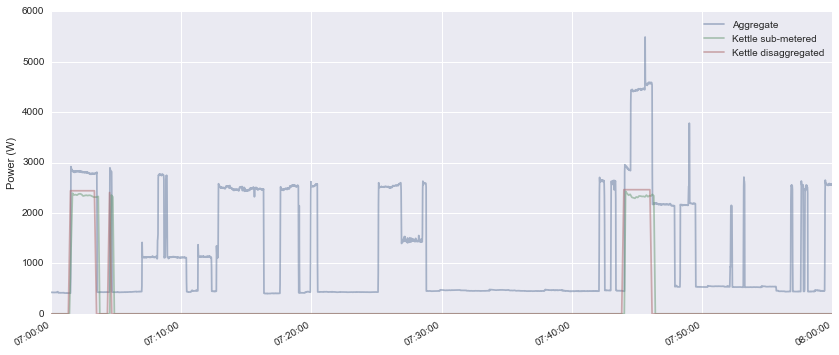

In [12]:
start = pd.Timestamp('2013-03-19 07:00')
end = pd.Timestamp('2013-03-19 08:00')
agg_psad[start:end].plot(alpha=0.5)
kettle[start:end].plot(alpha=0.5)
kettle_disag[start:end].plot(alpha=0.5)
plt.legend(['Aggregate','Kettle sub-metered','Kettle disaggregated'])
plt.ylabel('Power (W)')

In [13]:
disag_ds.store.close()

# Model Appliance Usage Patterns

In [14]:
# helper function

def dfDays(df): 

    date1 = df.index.min()
    date2 = df.index.max()
    dates = np.arange(date1,date2,timedelta(days=1))
    dates = pd.DataFrame(dates)
    dates.columns=['date_time']
    dates.index = dates.date_time
    return dates

In [15]:
# convert disaggregated kettle data into list of usage events

df = kettle_disag[kettle_disag.diff()>0].to_frame()
df.reset_index(inplace=True)
df.columns = ['date_time','power_delta']
df['event'] = 1
df['dayofweek'] = df.date_time.apply(lambda x: x.dayofweek)
df['month'] = df.date_time.apply(lambda x: x.month)
df['weekofyear'] = df.date_time.apply(lambda x: x.weekofyear)
df['week'] = df.date_time.apply(lambda x: x.week)
df['hour'] = df.date_time.apply(lambda x: x.hour)
df.set_index('date_time', inplace=True)
df.head()

,power_delta,event,dayofweek,month,weekofyear,week,hour
date_time,,,,,,,
2013-03-17 20:45:30+00:00,2383.110107,1,6,3,11,11,20
2013-03-18 06:57:30+00:00,2420.954987,1,0,3,12,12,6
2013-03-18 08:26:50+00:00,2412.694946,1,0,3,12,12,8
2013-03-18 18:16:30+00:00,2395.609985,1,0,3,12,12,18
2013-03-18 18:35:00+00:00,2352.379974,1,0,3,12,12,18


# Plot daily usage pattern

It can be seen that for this household, the kettle is highly likely to be used in the morning, somewhat likely at midday, and fairly likely in the evening. There is little night-time kettle usage.

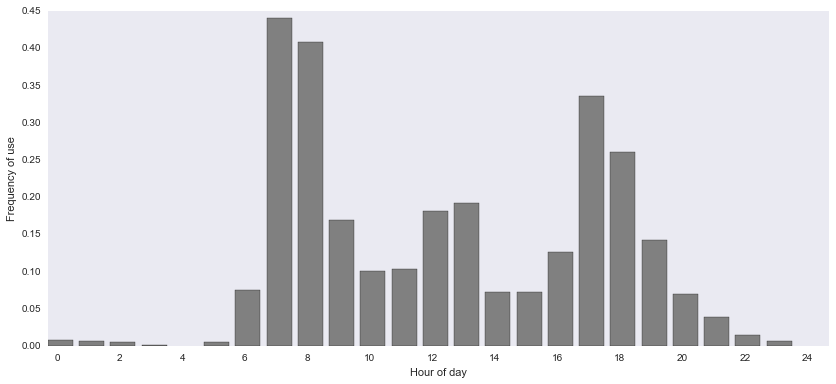

In [16]:
dates = dfDays(df)
ndays = len(dates)
grouped = pd.DataFrame(df.groupby('hour').agg('sum').event)
grouped['eventRatio'] = grouped.event / ndays
plt.figure(1)
plt.bar(grouped.index,grouped.eventRatio,color='gray')
plt.xticks(np.arange(0,25,2)+0.3,np.arange(0,25,2))

plt.xlabel('Hour of day')
plt.ylabel('Frequency of use')
plt.grid('off')

# Plot weekly usage pattern

It can be seen that the kettle used roughly the same frequency each day of the week.

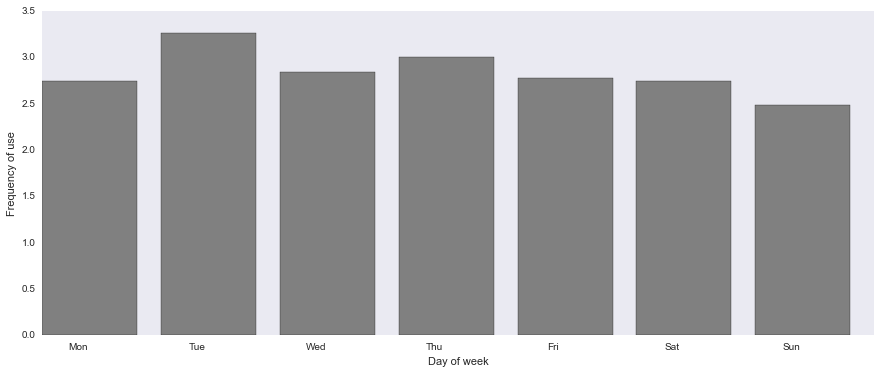

In [17]:
dates = dfDays(df)
dates['dayofweek'] = dates.index.dayofweek
grouped = pd.DataFrame(df.groupby('dayofweek').agg('sum').event)
grouped['number'] = dates.groupby('dayofweek').count()
grouped['eventRatio'] = grouped.event / grouped.number
plt.close()
plt.figure(2)
plt.clf()
plt.axes([0.116,0.20,0.825,0.75])
plt.bar(grouped.index,grouped.eventRatio,color='gray')
plt.xticks(np.arange(0,7,1)+0.3,['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.xlabel('Day of week')
plt.ylabel('Frequency of use')
plt.grid('off')

# Plot yearly usage pattern

It can be seen that there is a slight trend of more kettle usage in the winter, and less kettle usage in the summer. However, there is a large amount of variation due to different activities each week. Furthermore, some weeks show low kettle usage, which is likely a result of holidays.

(0, 52)

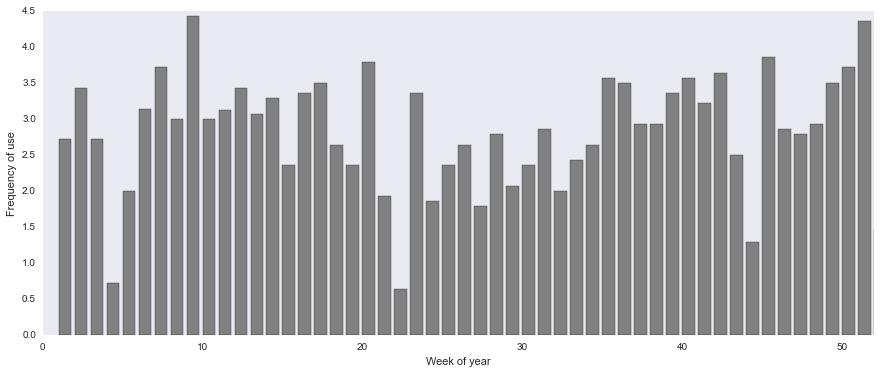

In [18]:
dates = dfDays(df)
dates['weekofyear'] = dates.index.weekofyear
grouped = pd.DataFrame(df.groupby('weekofyear').agg('sum').event)
grouped['number'] = dates.groupby('weekofyear').count()
grouped['eventRatio'] = grouped.event / grouped.number
plt.close()
plt.figure(3)
plt.clf()
plt.axes([0.114,0.20,0.825,0.75])
plt.bar(grouped.index,grouped.eventRatio,color='gray')
plt.xticks(np.arange(0,53,10))
plt.xlabel('Week of year')
plt.ylabel('Frequency of use')
plt.grid('off')
plt.xlim([0,52])

# Plot occurrences at half-hourly granularity over whole week

The repeating trend for each day can be seen clearly in both the histogram and point plot.

(0, 7)

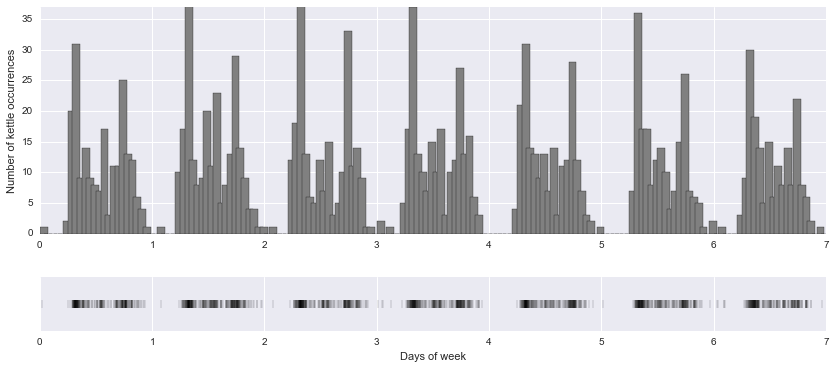

In [19]:
df['minute'] = df.index.minute
df['x'] = df.dayofweek * 1440 +df.hour * 60 + df.minute
binlength = 120 #Length of bins in minutes. 
sp = df.resample(str(binlength) + 'MIN', how='sum')
sp.fillna(0, inplace=True)
sp.event[sp.event > 0 ] = 1 
sp['hour'] = sp.index.hour
sp['minute'] = sp.index.minute
sp['dayofweek'] = sp.index.dayofweek
ocurrences = sp.groupby(['dayofweek','hour','minute']).event.sum()
daylength = pd.DataFrame(columns=['x','y'])
daylength['y'] = ocurrences.reset_index().event
daylength['x'] = ocurrences.reset_index().dayofweek * 1440 + ocurrences.reset_index().hour * 60 + ocurrences.reset_index().minute

ax1 = plt.axes([0.125,0.350,0.78,0.525])
plt.bar(daylength.x / float(1440),daylength.y, width=0.07, color='gray')
plt.ylabel('Number of kettle occurrences')
plt.xlim([0,7])
plt.ylim([0,37])
ax2 = plt.axes([0.125,0.125,0.78,0.125])
plt.scatter(df.x / float(1440), df.event * 0,s=60,alpha=0.6,c='black',marker='|')
plt.xlabel('Days of week')
plt.gca().get_yaxis().set_visible(False)
plt.xlim([0,7])

In [20]:
# create inputs for Log-Gaussian Cox Process

X = daylength.x.values
X = np.array(X)
Y = daylength.y.values
Y = np.array(Y)
minutes_by_week = 7 * 24 * 60
scale = 1
X =  scale * X / float(minutes_by_week) # Scaling to 1
X1 = X.reshape(-1,1) 
Y1 = Y.reshape(-1,1) 
Xp = np.concatenate((X, X + scale), axis=0)  # For periodicity
Yp = np.concatenate((Y,Y), axis=0)
Xp = Xp.reshape(-1,1) 
Yp = Yp.reshape(-1,1) 

In [21]:
# hyper-parameters for daily periodicity
d = 1 
var = 2
theta = 1. * scale / len(X)
thea_daily=theta
p = 1./7
# kernel with daily periodicity 
kernel_dayly = GPy.kern.PeriodicExponential(d,variance=var, lengthscale=theta, period=p)
kernel_dayly.period.constrain_fixed()

# hyper-parameters for weekly periodicity
d = 1 
var = 1
theta = 10. * scale / len(X)
p = 1.
# kernel with weekly periodicity
kernel_weekly = GPy.kern.PeriodicExponential(d,variance=var, lengthscale=10 *theta, period=p)
kernel_weekly.period.constrain_fixed()

array([0])

# Plot covariance between mid-night on Monday and every point over the following week

We encode in our model that appliance usage at mid-night on Monday is:
1. most similar to midnight on Monday in the following week
2. fairly similar to midnight on the other days of this week
3. slightly similar to 2am on Monday this week

(0, 1)

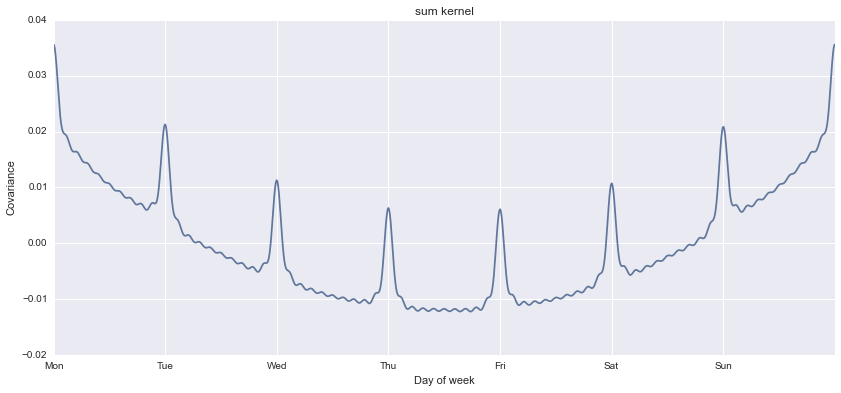

In [22]:
# sum both kernels

kernel = kernel_dayly + kernel_weekly
kernel.plot(resolution=10000)
plt.xlabel('Day of week')
plt.ylabel('Covariance')
plt.xticks(np.arange(0,1,1/7.),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.xlim([0,1])

In [23]:
# Poisson likelihood
poisson_likelihood = GPy.likelihoods.Poisson()
# inference method
laplace_inf = GPy.inference.latent_function_inference.Laplace()
# GP
m = GPy.core.GP(X=Xp, Y=Yp, likelihood=poisson_likelihood, inference_method=laplace_inf, kernel=kernel)

In [24]:
dates['dayofweek'] = dates.index.dayofweek
weeks = dates.groupby('dayofweek').count()
weekdays = np.arange(0,7,1)
week_in_minutes = 7. * 24. * 60.
# Date 
df['date'] = df.index.date
# Iterating by weekdays:
X = np.array([])
Y_mean = np.array([])
Y_upper = np.array([])
Y_lower = np.array([])
for day in weekdays: 
    minutes1 = day * 1440.
    minutes2 = minutes1 + 1439.
    ndays = weeks.loc[day].values[0]

    # PDF
    regresion_points = 100.
    x1 = minutes1 / week_in_minutes
    x2 = (minutes2) / week_in_minutes
    x = X1[np.where((X1>=x1) & (X1<=x2))]
    y = Y1[np.where((X1>=x1) & (X1<=x2))]
    norma = regresion_points/len(x)
    pred_points = np.linspace(minutes1/week_in_minutes,minutes2/week_in_minutes,regresion_points)[:,None]
    # Predictive GP for log intensity mean and variance
    f_mean, f_var = m._raw_predict(pred_points)
    f_upper, f_lower = f_mean + 2*np.sqrt(f_var), f_mean - 2.*np.sqrt(f_var)
    pdf_mean = np.exp(f_mean) / float(ndays)
    pdf_var = np.exp(f_var) / float(ndays)
    pdf_upper = np.exp(f_upper) / float(ndays)
    pdf_lower = np.exp(f_lower) / float(ndays)

    X = np.append(X,pred_points)
    Y_mean= np.append(Y_mean,pdf_mean)
    Y_upper= np.append(Y_upper,pdf_upper)
    Y_lower= np.append(Y_lower,pdf_lower)

# Plot learned probability density function (PDF)

The model describing the probability of kettle usage can be seen below, which was calculated from the disaggregated kettle data (as opposed to the sub-metered kettle data). This model can be used be calculate the probability that the household has deviated from their normal routine of kettle usage, e.g. using the appliance less often or using it at different times of day. For further details see our paper:

José Alcalá, Oliver Parson, Alex Rogers. [Detecting Anomalies in Activities of Daily Living of ElderlyResidents via Energy Disaggregation and Cox Processes](http://eprints.soton.ac.uk/381714/). In: 2nd ACM International Conference on Embedded Systems For Energy-Efficient Built Environments (BuildSys), Seoul, South Korea. 2015.

([<matplotlib.axis.XTick at 0x10e9c7210>,
 <a list of 7 Text xticklabel objects>)

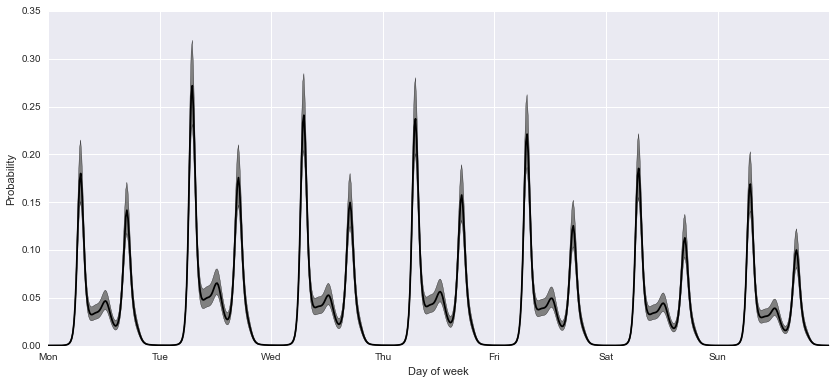

In [25]:
plt.fill_between(X, Y_lower, Y_upper,facecolor='gray')
plt.plot(X, Y_mean,'k',label='PDF')
plt.ylabel('Probability')
plt.xlabel('Day of week')
plt.ylim([0,plt.ylim()[1]])
plt.xticks(np.arange(0,1,1/7.),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])